## Problem Statment



1. Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.
2. What are the main factors that drive employee churn? Do they make sense? Explain your findings.
3. If you could add to this data set just one variable that could help explain employee churn, what would that be?

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

import datetime

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

import graphviz

%matplotlib inline


## Load Data and basic EDA

In [2]:
#converts dates to datetime
data = pd.read_csv('employee_retention_data.csv', parse_dates=['join_date', 'quit_date'])
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
#check data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [4]:
#check nulls
data.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [5]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


Takeaways:
1. Employee ids do not seem to be continuous (min, max and count dont add up)
2. Outlier in seniority - 99 ?
3. Outlier in salary ?

In [6]:
#check if all employee ids are unique, count the umber of unique companies and departments

print('Number of unique employees:',len(data.employee_id.unique()))
print('Number of unique companies:',len(data.company_id.unique()))
print('Number of unique departments:',len(data.dept.unique()))

Number of unique employees: 24702
Number of unique companies: 12
Number of unique departments: 6


In [7]:
data.describe(include = [np.object])

,dept
count,24702
unique,6
top,customer_service
freq,9180


13210 out of 24702 employees have quit

In [8]:
#Lets see the distribution according to department
data.groupby('dept').agg('count')

,employee_id,company_id,seniority,salary,join_date,quit_date
dept,,,,,,
customer_service,9180,9180,9180,9180,9180,5094
data_science,3190,3190,3190,3190,3190,1682
design,1380,1380,1380,1380,1380,778
engineer,4613,4613,4613,4613,4613,2362
marketing,3167,3167,3167,3167,3167,1783
sales,3172,3172,3172,3172,3172,1811


Most employees work in customer service

dept
customer_service     82245.424837
marketing           135598.042311
sales               135912.358134
design              137460.869565
engineer            205544.548016
data_science        206885.893417
Name: salary, dtype: float64


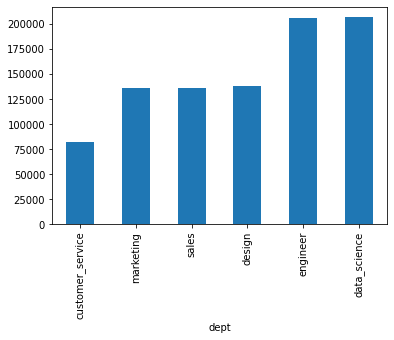

In [9]:
#Lets see the pay per department

print(data.groupby('dept')['salary'].mean().sort_values())
data.groupby('dept')['salary'].mean().sort_values().plot(kind='bar')

Customer service gets paid the least, but has the most employees working for them. They also have the most people leaving their jobs.

In [10]:
data.groupby('dept')['employee_id'].count().sort_values()

dept
design              1380
marketing           3167
sales               3172
data_science        3190
engineer            4613
customer_service    9180
Name: employee_id, dtype: int64

In [11]:
#lets look at the outliers in seniority
data.groupby('seniority').count()

,employee_id,company_id,dept,salary,join_date,quit_date
seniority,,,,,,
1,861,861,861,861,861,430
2,942,942,942,942,942,500
3,881,881,881,881,881,447
4,895,895,895,895,895,422
5,936,936,936,936,936,533
6,950,950,950,950,950,571
7,928,928,928,928,928,511
8,1008,1008,1008,1008,1008,586
9,944,944,944,944,944,522


In [12]:
#remove the last two- they look like outliers

data = data[data['seniority'] < 30]
data.groupby('seniority').count()

,employee_id,company_id,dept,salary,join_date,quit_date
seniority,,,,,,
1,861,861,861,861,861,430
2,942,942,942,942,942,500
3,881,881,881,881,881,447
4,895,895,895,895,895,422
5,936,936,936,936,936,533
6,950,950,950,950,950,571
7,928,928,928,928,928,511
8,1008,1008,1008,1008,1008,586
9,944,944,944,944,944,522


## 1. Create Headcount Table

In [13]:
#we want day, employee_headcount and company_id

unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(data['company_id'].unique())

In [14]:
day = []
company =[]
headcount = []

In [15]:
for date in unique_date:
    for idx in unique_company:
        total_join = len(data[(data['join_date'] <= date) & (data['company_id'] == idx)])
        total_quit = len(data[(data['quit_date'] <= date) & (data['company_id'] == idx)])
        day.append(date)
        company.append(idx)
        headcount.append(total_join - total_quit)

In [16]:
headcountTable = pd.DataFrame({'day': day, 'company_id': company, 'employee_headcount': headcount}, 
                     columns=['day', 'company_id', 'employee_headcount'])

In [17]:
headcountTable.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


## 2. Employee Churn Analysis

In [26]:
#Analyse stay and quit data seperately

stay_data = data[data['quit_date'].isnull()]
quit_data = data[~data['quit_date'].isnull()]

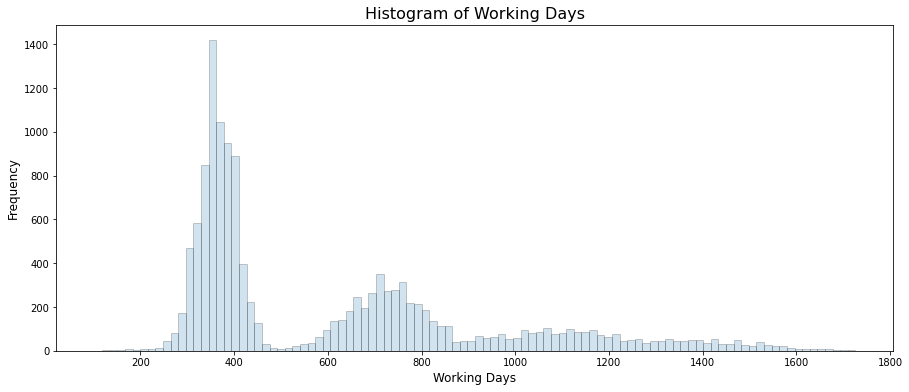

In [27]:
#total working days

work_days = np.array(list(map(lambda x: x.days, quit_data['quit_date'] - quit_data['join_date'])))

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(work_days, bins=100, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

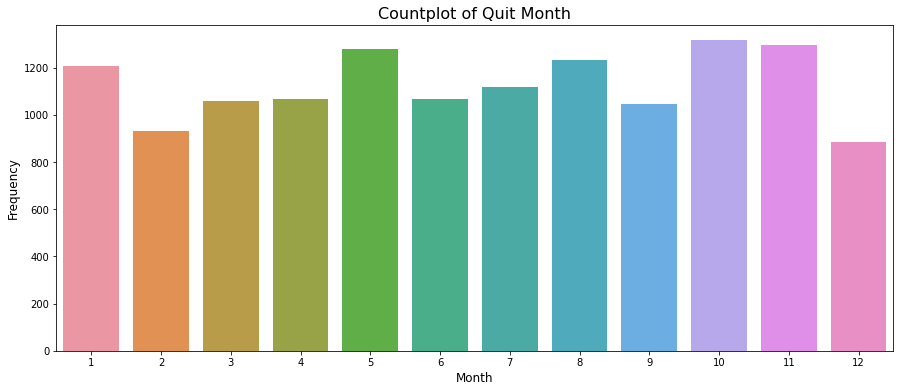

In [28]:
# Month No. for quiting
quit_week = np.array(list(map(lambda x: x.month, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax)
ax.set_title('Countplot of Quit Month', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()


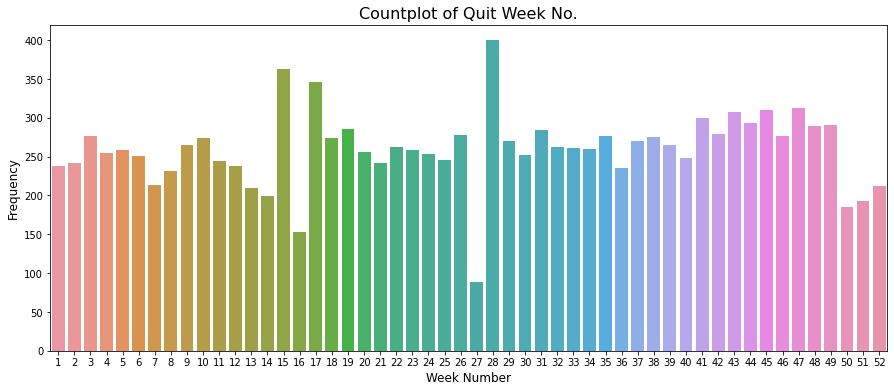

In [29]:
# Week No. for quiting
quit_week = np.array(list(map(lambda x: x.week, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax)
ax.set_title('Countplot of Quit Week No.', fontsize=16)
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()


In [30]:
#add quit work week and days 
quit_data['work_days'] = work_days
quit_data['quit_week'] = quit_week

quit_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,work_days,quit_week
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,44
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,14
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,23
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,34
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578,35


## Decision Tree

In [23]:
## Choose data to model on

stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=365 + 31)
subset = data[data['join_date'] < stop_date]

In [31]:
## Binary label for quitting less than 13 months into the job

quit = subset['quit_date'].isnull() | (subset['quit_date'] > subset['join_date'] + pd.DateOffset(days=396))
subset['quit'] = 1 - quit.astype(int)

subset.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


In [33]:
#LabelEncoder

LE = LabelEncoder()

train_x = subset[['company_id', 'seniority', 'salary']]

#label encode on department
train_x['dept'] = LE.fit_transform(subset['dept'])

train_y = subset['quit'].values

train_x.head()

,company_id,seniority,salary,dept
0,7,28,89000.0,0
1,7,20,183000.0,4
2,4,14,101000.0,4
3,7,20,115000.0,0
4,2,23,276000.0,1


In [34]:
# Build decision tree
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X=train_x, y=train_y)

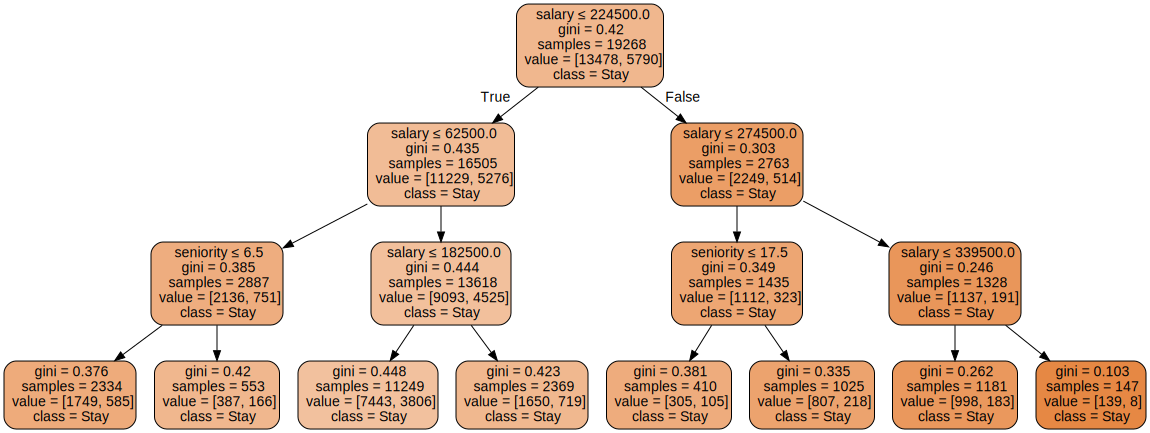

In [41]:
# Visualization
features = list(train_x.columns)
targets = ['Stay', 'Quit']
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=targets, 
                                filled=True, rounded=True, special_characters=True, )  
graph = graphviz.Source(dot_data)
graph

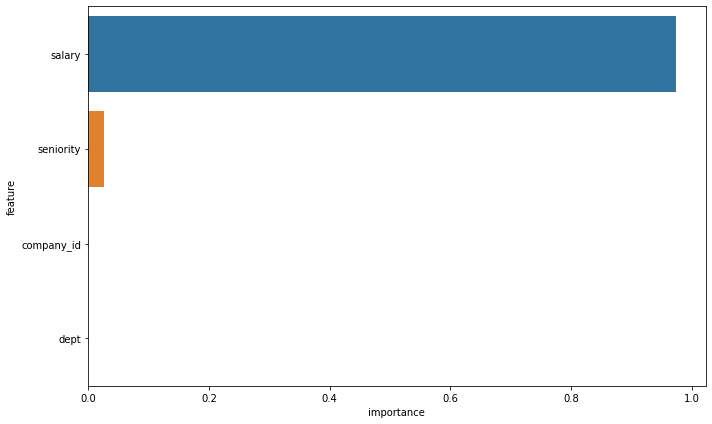

In [38]:
importances = clf.feature_importances_
featureDF = pd.DataFrame({'feature': features, 'importance': importances})
featureDF.sort_values(by='importance', ascending=False, inplace=True)

# Display a horizontal barplot with the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=featureDF['importance'], y=featureDF['feature'], orient='h')
plt.tight_layout()

HUGE importance to salary, folowed by seniority

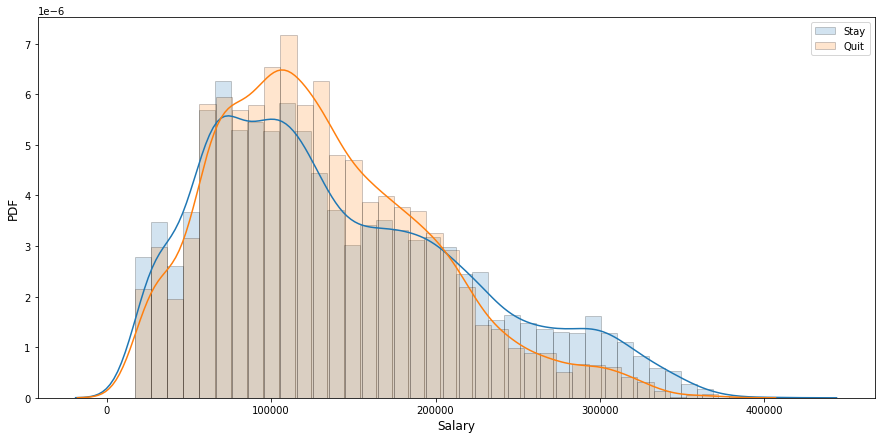

In [39]:
# Visualization
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(subset[subset['quit']==0]['salary'], 
             label='Stay', ax=ax, hist_kws=hist_kws)
sns.distplot(subset[subset['quit']==1]['salary'], 
             label='Quit', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('Salary', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()

Takeaways:

1. Most people's salaries pay a huge role on their decision to quit. Including the salary the employee who quit's next job offers may be a good way to combat quitting because of salary deficiency.
2. As seen by the graph, employees are less likely to quit if they have extremely high or extremely low salaries. Low salary employees may not get better job prospects, and so decide to stay.
3. Seeing the working days, most employees quit when they work around 1-1.5 years. An employee usually gets stock within one year of employment, so that makes sense.